<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#EDA" data-toc-modified-id="EDA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Preprocessing-Data" data-toc-modified-id="Preprocessing-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preprocessing Data</a></span></li><li><span><a href="#Building-Decision-Tree-Model" data-toc-modified-id="Building-Decision-Tree-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Building Decision Tree Model</a></span></li><li><span><a href="#Evaluating-Model" data-toc-modified-id="Evaluating-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Evaluating Model</a></span><ul class="toc-item"><li><span><a href="#Classification-Report" data-toc-modified-id="Classification-Report-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Classification Report</a></span></li><li><span><a href="#Confusion-Matrix" data-toc-modified-id="Confusion-Matrix-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Confusion Matrix</a></span></li><li><span><a href="#ROC-Curve" data-toc-modified-id="ROC-Curve-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>ROC Curve</a></span></li></ul></li><li><span><a href="#Feature-Visualisation" data-toc-modified-id="Feature-Visualisation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Feature Visualisation</a></span></li><li><span><a href="#Feature-Importance" data-toc-modified-id="Feature-Importance-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Feature Importance</a></span></li></ul></div>

# EDA

In [1]:
# import modules
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import pydotplus
import numpy as np


plt.style.use('ggplot')
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)
%matplotlib inline

In [2]:
file = 'data/agaricus-lepiota.data'
df = pd.read_csv(file)

In [3]:
profile = ProfileReport(df, title='Mushroom Profiling Report', html={'style':{'full_width':True}})

In [4]:
profile.to_widgets()

# Data

In [5]:
# rename columns
df.rename(columns={'p':'classes', 'x':'cap_shape', 's':'cap_surface', 
                  'n':'cap_color', 't':'bruises_?', 'p.1':'odor', 'f':'gill_attachment', 
                  'c':'gill_spacing', 'n.1':'gill_size', 'k':'gill_color', 'e':'stalk_shape', 
                  'e.1':'stalk_root', 's.1':'stalk_surface_above_ring', 's.2':'stalk_surface_below_ring', 
                  'w':'stalk_color_above_ring', 'w.1':'stalk_color_below_ring', 'p.2':'veil_type', 
                  'w.2':'veil_color', 'o':'ring_number', 'p.3':'ring_type', 'k.1':'spore_print_color', 
                  's.3':'population', 'u':'habitat'}, inplace=True)

In [6]:
# Replace the '?'s with NaN
df = df.replace('?', np.nan)

In [7]:
df.isnull().sum()

classes                        0
cap_shape                      0
cap_surface                    0
cap_color                      0
bruises_?                      0
odor                           0
gill_attachment                0
gill_spacing                   0
gill_size                      0
gill_color                     0
stalk_shape                    0
stalk_root                  2480
stalk_surface_above_ring       0
stalk_surface_below_ring       0
stalk_color_above_ring         0
stalk_color_below_ring         0
veil_type                      0
veil_color                     0
ring_number                    0
ring_type                      0
spore_print_color              0
population                     0
habitat                        0
dtype: int64

In [8]:
for col in df:
    if df[col].dtype == 'object':
        df = df.fillna(df[col].value_counts().index[0])
        
print(df.isnull().sum())

classes                     0
cap_shape                   0
cap_surface                 0
cap_color                   0
bruises_?                   0
odor                        0
gill_attachment             0
gill_spacing                0
gill_size                   0
gill_color                  0
stalk_shape                 0
stalk_root                  0
stalk_surface_above_ring    0
stalk_surface_below_ring    0
stalk_color_above_ring      0
stalk_color_below_ring      0
veil_type                   0
veil_color                  0
ring_number                 0
ring_type                   0
spore_print_color           0
population                  0
habitat                     0
dtype: int64


In [9]:
df['classes'].value_counts()

e    4208
p    3915
Name: classes, dtype: int64

> Mushrooms are either classified as edible (e) or poisonous (p). The above output outlines the prevalence of mushrooms in the dataset

In [10]:
#split dataset in features and target variable
X = df[df.columns[1:]]
y = df.classes


In [11]:
# encode categorical features and replace target values to binary values
X_dummy = pd.get_dummies(X)
y_dummy = df['classes'].replace(['e', 'p'], [1, 0])

In [12]:
kf = StratifiedKFold(n_splits=2, shuffle=False, random_state=42)
kf.get_n_splits(X_dummy, y_dummy)

2

In [13]:
for train_index, test_index in kf.split(X_dummy, y_dummy):
    X_train, X_test = X_dummy.iloc[train_index], X_dummy.iloc[test_index]
    y_train, y_test = y_dummy.iloc[train_index], y_dummy.iloc[test_index]

print(y_train.shape, X_train.shape)
print(y_test.shape, X_test.shape)

(4062,) (4062, 116)
(4061,) (4061, 116)


# Building Decision Tree Model

In [14]:
clf = DecisionTreeClassifier(criterion='gini', random_state=42)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

# Evaluating Model

## Classification Report

In [15]:
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.accuracy_score(y_train, y_pred_train))

0.9753755232701306
1.0


In [16]:
print('Decision Tree classification report:')
print('Test set', classification_report(y_test, y_pred))            
print('\n')
print('Train set', classification_report(y_train, y_pred_train))

Decision Tree classification report:
Test set               precision    recall  f1-score   support

           0       0.97      0.98      0.97      1957
           1       0.98      0.97      0.98      2104

   micro avg       0.98      0.98      0.98      4061
   macro avg       0.98      0.98      0.98      4061
weighted avg       0.98      0.98      0.98      4061



Train set               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1958
           1       1.00      1.00      1.00      2104

   micro avg       1.00      1.00      1.00      4062
   macro avg       1.00      1.00      1.00      4062
weighted avg       1.00      1.00      1.00      4062



> The above classification report indicates that the model performs better on the training set than on the test set, but only by a small margin.


## Confusion Matrix

In [17]:
print('Test set\n', confusion_matrix(y_test, y_pred))
print('\n')
print('Train set\n',confusion_matrix(y_train, y_pred_train))

Test set
 [[1917   40]
 [  60 2044]]


Train set
 [[1958    0]
 [   0 2104]]


## ROC Curve

In [18]:
dt_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, threshold_log = roc_curve(y_test, y_pred)

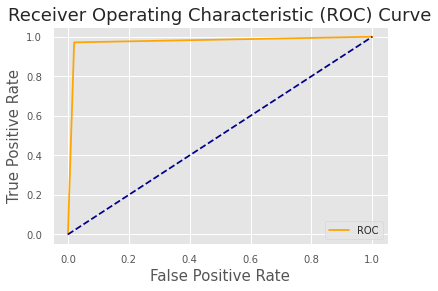

In [19]:
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

> The ROC Curve also supports the high accuracy of the model.

# Feature Visualisation

In [20]:
dict = {'feature': X_train.columns, 'feature_importance':clf.feature_importances_}
new_df = pd.DataFrame(dict)
new_df.sort_values('feature_importance',axis=0,ascending=False,inplace=True)

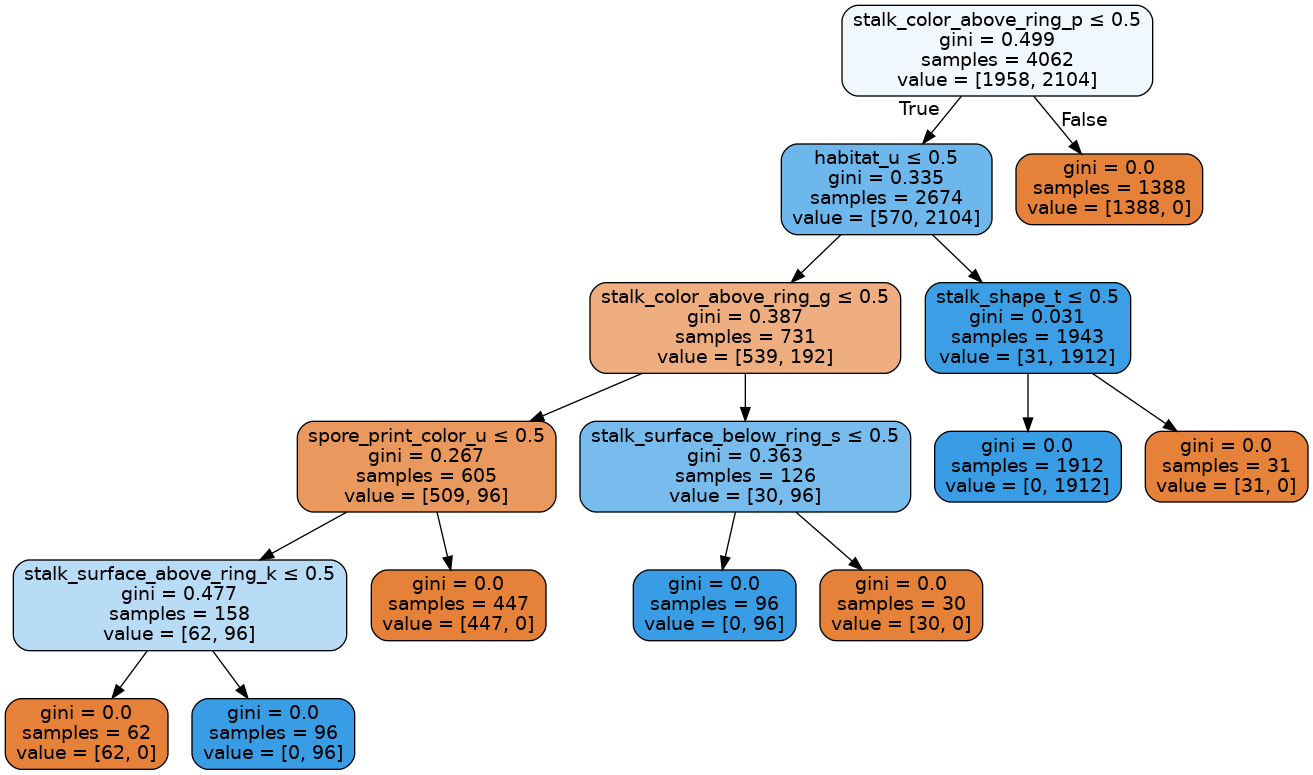

In [21]:
dot_data = StringIO()
export_graphviz(clf,feature_names=list(new_df['feature']), out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# Feature Importance

In [22]:
new_df = new_df[new_df["feature_importance"] > 0.05]
new_df

,feature,feature_importance
24,odor_f,0.557778
35,gill_size_b,0.272554


> Factors that predict the status of mushrooms.